# 精度の推移

In [1]:
import os

col = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3']
root = os.path.join("..", "save", "teachers", "models")
files = {
    "finetuning(training classifier only)": "vgg16_bn-fe-cifar100-trial_0-epochs_240-bs_64-20251005",
    "finetuning": "vgg16_bn-ft-cifar100-trial_0-epochs_240-bs_64-20251006",
    "scratch": "vgg16_bn-scratch-cifar100-trial_0-epochs_240-bs_64-20251005",
    "self-implemented": "vgg16_bn-cifar100-trial_0-epochs_240-bs_64-20251006",
}
files = {k: os.path.join(root, v) for k, v in files.items()}

In [2]:
from tensorboard.backend.event_processing import event_accumulator
import json
import os

def load_data(path, test_or_train):
    acc = None
    if "models" in path:
        file = "training_history.json"
        path = os.path.join(path, file)
        # JSONファイルを読み込む
        with open(path, "r") as f:
            data = json.load(f)
        # "train_acc" または "test_acc" を取得
        key = test_or_train + "_acc"
        acc = data.get(key, [])
    elif "tensorboard" in path:
        ea = event_accumulator.EventAccumulator(path)
        ea.Reload() 
        # print("Scalars:", ea.Tags()['scalars'])
        tags = ["_acc", "/acc"]
        tags = [test_or_train + t for t in tags]
        for tag in tags:
            if tag in ea.Tags()["scalars"]:
                acc = ea.Scalars(tag)
                acc = [x.value for x in acc]
                break
    return acc

-- finetuning(training classifier only) --
max_acc_test(finetuning(training classifier only)): 37.69
-- finetuning --
max_acc_test(finetuning): 74.68
-- scratch --
max_acc_test(scratch): 73.07
-- self-implemented --
max_acc_test(self-implemented): 73.52


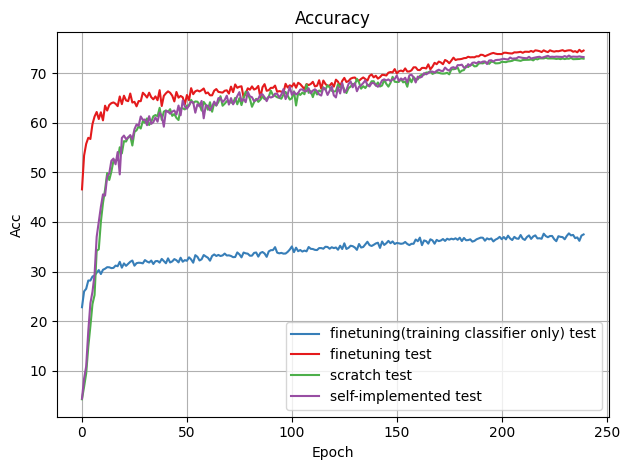

In [3]:
# tensorboardからデータをとり、グラフ描画
import matplotlib.pyplot as plt
import os

zoom = False
plot_test = True
plot_train = False

# グラフ描画
for idx, (label, path) in enumerate(files.items()):
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue
    # ログファイルのパスを指定（ログディレクトリか、eventファイルを直接）
    print("--", label, "--")
    
    if plot_test:
        acc_test = load_data(path, "test")
        # print(acc_test)
        plt.plot(acc_test, label=label+" test", linestyle = "-", color = col[idx])
        if zoom == True:
            plt.xlim(len(acc_test)-50, len(acc_test))  # 横軸を最後の50エポックに限定
        # 各系列の最大値
        max_acc_test = max(acc_test)
        print("max_acc_test({}): {}".format(label, max_acc_test))
        max_epoch = acc_test.index(max_acc_test) + 1
        # plt.text(len(acc_test), acc_test[-1], f"{label}: {max_acc_test:.2f}", fontsize=9)     
         
    if plot_train:
        acc_train = load_data(path, "test")
        plt.plot(acc_train, label=label+" train", linestyle = ":", color = col[idx])
        if zoom == True:
            plt.xlim(len(acc_train)-50, len(acc_train))  # 横軸を最後の50エポックに限定
        # 各系列の最大値
        max_acc_train = max(acc_train)
        print("max_acc_train({}): {}".format(label, max_acc_train))
        max_epoch = acc_train.index(max_acc_train) + 1
        # plt.text(len(acc_train), acc_train[-1], f"{label}: {max_acc_train:.2f}", fontsize=9)  

# グラフ整形
if zoom == True:
    plt.ylim(70,80)   
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.title("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 精度の平均値

In [20]:
from tensorboard.backend.event_processing import event_accumulator
import json
import os

def load_data(path, test_or_train):
    acc = None
    if "models" in path:
        file = test_or_train + "_acc_history.json"
        path = os.path.join(path, file)
        # JSONファイルを読み込む
        with open(path, "r") as f:
            data = json.load(f)
        # "test_acc" のリストを取得
        acc = data["test_acc"]
    elif "tensorboard" in path:
        ea = event_accumulator.EventAccumulator(path)
        ea.Reload() 
        # print("Scalars:", ea.Tags()['scalars'])
        tags = ["_acc", "/acc"]
        tags = [test_or_train + t for t in tags]
        for tag in tags:
            if tag in ea.Tags()["scalars"]:
                acc = ea.Scalars(tag)
                acc = [x.value for x in acc]
                break
    return acc

In [15]:
import os

folder = os.path.join("..", "save", "students", "models")
model_dir = {
    "Base": "S_vgg13-T_vgg13-cifar10-kd-r_1.0-a_1.0-b_400.0-b_method_exp-0",
    "Ours-4U": "S_vgg13-T_vgg13-cifar10-ckad-r_1.0-a_1.0-b_400.0-b_method_exp-0-Distill_gn-4-me_mean-red_mean-sgrp_uniform",
    "Ours-11U": "S_vgg13-T_vgg13-cifar10-ckad-r_1.0-a_1.0-b_400.0-b_method_exp-0-Distill_gn-11-me_mean-red_mean-sgrp_uniform",
    "Ours-4P": "S_vgg13-T_vgg13-cifar10-ckad-r_1.0-a_1.0-b_400.0-b_method_exp-0-Distill_gn-4-me_mean-red_mean-sgrp_proportional",
}

# フォルダ内の全ファイル
all_files = os.listdir(folder)

# 各 value をリストに置き換える
for key in model_dir:
    prefix = model_dir[key]
    model_dir[key] = [os.path.join(folder, f) for f in all_files if f.startswith(prefix)]

# 確認
for key, files in model_dir.items():
    print(f"{key}: {len(files)} files")

Base: 7 files
Ours-4U: 7 files
Ours-11U: 7 files
Ours-4P: 7 files


In [22]:
# 結果を格納する辞書
max_acc_dict = {}
avg_max_acc_dict = {}

for key, paths in model_dir.items():
    # 各ファイルの test データ精度リストを取得
    acc_lists = [load_data(path, "test") for path in paths]
    
    # 各ファイルの最大精度
    max_acc_list = [max(acc) for acc in acc_lists]
    max_acc_dict[key] = max_acc_list
    
    # そのキーの全ファイルの最大精度平均
    avg_max_acc_dict[key] = sum(max_acc_list) / len(max_acc_list)

# 確認
for key in model_dir.keys():
    print(f"{key}: max per file = {max_acc_dict[key]}, avg max = {avg_max_acc_dict[key]:.4f}")


Base: max per file = [94.43, 94.38, 94.4, 94.45, 94.37, 94.61, 94.32], avg max = 94.4229
Ours-4U: max per file = [94.49, 94.35, 94.59, 94.18, 94.14, 94.42, 94.14], avg max = 94.3300
Ours-11U: max per file = [94.3, 94.29, 94.38, 94.29, 94.29, 94.36, 94.55], avg max = 94.3514
Ours-4P: max per file = [94.54, 94.59, 94.6, 94.39, 94.44, 94.45, 94.48], avg max = 94.4986
